In [1]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [3]:
train_dir = 'D:\Semester 5\DPL302m\slot8\horse-or-human\\train'
test_dir = 'D:\Semester 5\DPL302m\slot8\horse-or-human\\test'
valid_dir = 'D:\Semester 5\DPL302m\slot8\horse-or-human\\validation'

In [12]:
#tao tap test
import os
import shutil
from sklearn.model_selection import train_test_split

def create_test_set(source_dir, test_dir, split_ratio=0.2):
    categories = ['horses', 'humans']
    
    for category in categories:
        src_path = os.path.join(source_dir, category)
        dest_path = os.path.join(test_dir, category)
        
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        
        # Lấy danh sách tất cả các tệp tin trong thư mục nguồn
        files = os.listdir(src_path)
        
        # Chia các tệp tin thành tập test và tập train
        _, test_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        # Di chuyển các tệp tin từ thư mục train sang thư mục test
        for file in test_files:
            shutil.move(os.path.join(src_path, file), os.path.join(dest_path, file))
            print(f"Moved {file} to {dest_path}")

In [13]:
#create_test_set(valid_dir,test_dir)

Moved horse3-255.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse1-105.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse2-441.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse3-397.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse2-254.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse3-198.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse1-510.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse5-504.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse1-241.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse2-011.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse4-503.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse3-498.png to D:\Semester 5\DPL302m\slot8\horse-or-human\test\horses
Moved horse5-405.png to D:\Semester 5\DPL302m\slot8\

In [14]:
# Lặp qua các thư mục con (đại diện cho các lớp)
def data_frame(img_folder_path):
    filenames = []
    labels = []
    for folder_name in os.listdir(img_folder_path):
        folder_path = os.path.join(img_folder_path, folder_name)
        if os.path.isdir(folder_path):  # Kiểm tra xem đây có phải là thư mục không
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if os.path.isfile(file_path):
                    filenames.append(file_path)
                    labels.append(folder_name)  # Sử dụng tên thư mục làm nhãn
    return pd.DataFrame({"filename": filenames, "label": labels})

# Hiển thị 5 hàng đầu của DataFrame
df_train = data_frame(train_dir)
df_test = data_frame(test_dir)
df_valid = data_frame(valid_dir)

In [17]:
display(df_train.head(),df_train.tail())

,filename,label
0,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,horses
1,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,horses
2,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,horses
3,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,horses
4,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,horses


,filename,label
1022,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,humans
1023,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,humans
1024,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,humans
1025,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,humans
1026,D:\Semester 5\DPL302m\slot8\horse-or-human\tra...,humans


In [18]:
print('The shape of train data',df_train.shape)
print('The shape of test data',df_test.shape)
print('The shape of validation data',df_valid.shape)

The shape of train data (1027, 2)
The shape of test data (43, 2)
The shape of validation data (166, 2)


In [135]:
# parameters
image_size = 128
image_channel = 3
bat_size = 16

In [136]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.2,
                                    fill_mode = 'nearest',
                                    width_shift_range = 0.2,
                                    height_shift_range = 00.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [137]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    class_mode='binary',
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(df_valid, 
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 class_mode='binary',
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(df_test, 
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  class_mode='binary',
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 1027 validated image filenames belonging to 2 classes.
Found 166 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.


In [157]:
model = Sequential()

# Input Layer
model.add(Conv2D(16,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


# Fully Connected layers 
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1,activation='sigmoid'))

model.summary()


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_146 (Conv2D)             │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_181         │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_146               │ (None, 63, 63, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 61, 61, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_182         │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_183         │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_184         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,508,481 (24.83 MB)

 Trainable params: 6,507,553 (24.82 MB)

 Non-trainable params: 928 (3.62 KB)

In [158]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 20,restore_best_weights=True,verbose=0)

In [159]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [160]:
horses_humans = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 50,
                    #steps_per_epoch = len(train_generator),
                    #validation_steps = len(val_generator),
                   )

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.6963 - loss: 0.7408 - val_accuracy: 0.3855 - val_loss: 6.9320 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 203ms/step - accuracy: 0.8410 - loss: 0.3804 - val_accuracy: 0.6145 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.8749 - loss: 0.2939 - val_accuracy: 0.6145 - val_loss: 4.1772 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9016 - loss: 0.2363
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.9014 - loss: 0.2367 - val_accuracy: 0.6145 - val_loss: 3.0212 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.9068 - loss: 0.2139 - val_accuracy: 0.6145 - val_loss: 1.5600 - learning_rate: 5.0000e-04
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.9233 - loss: 

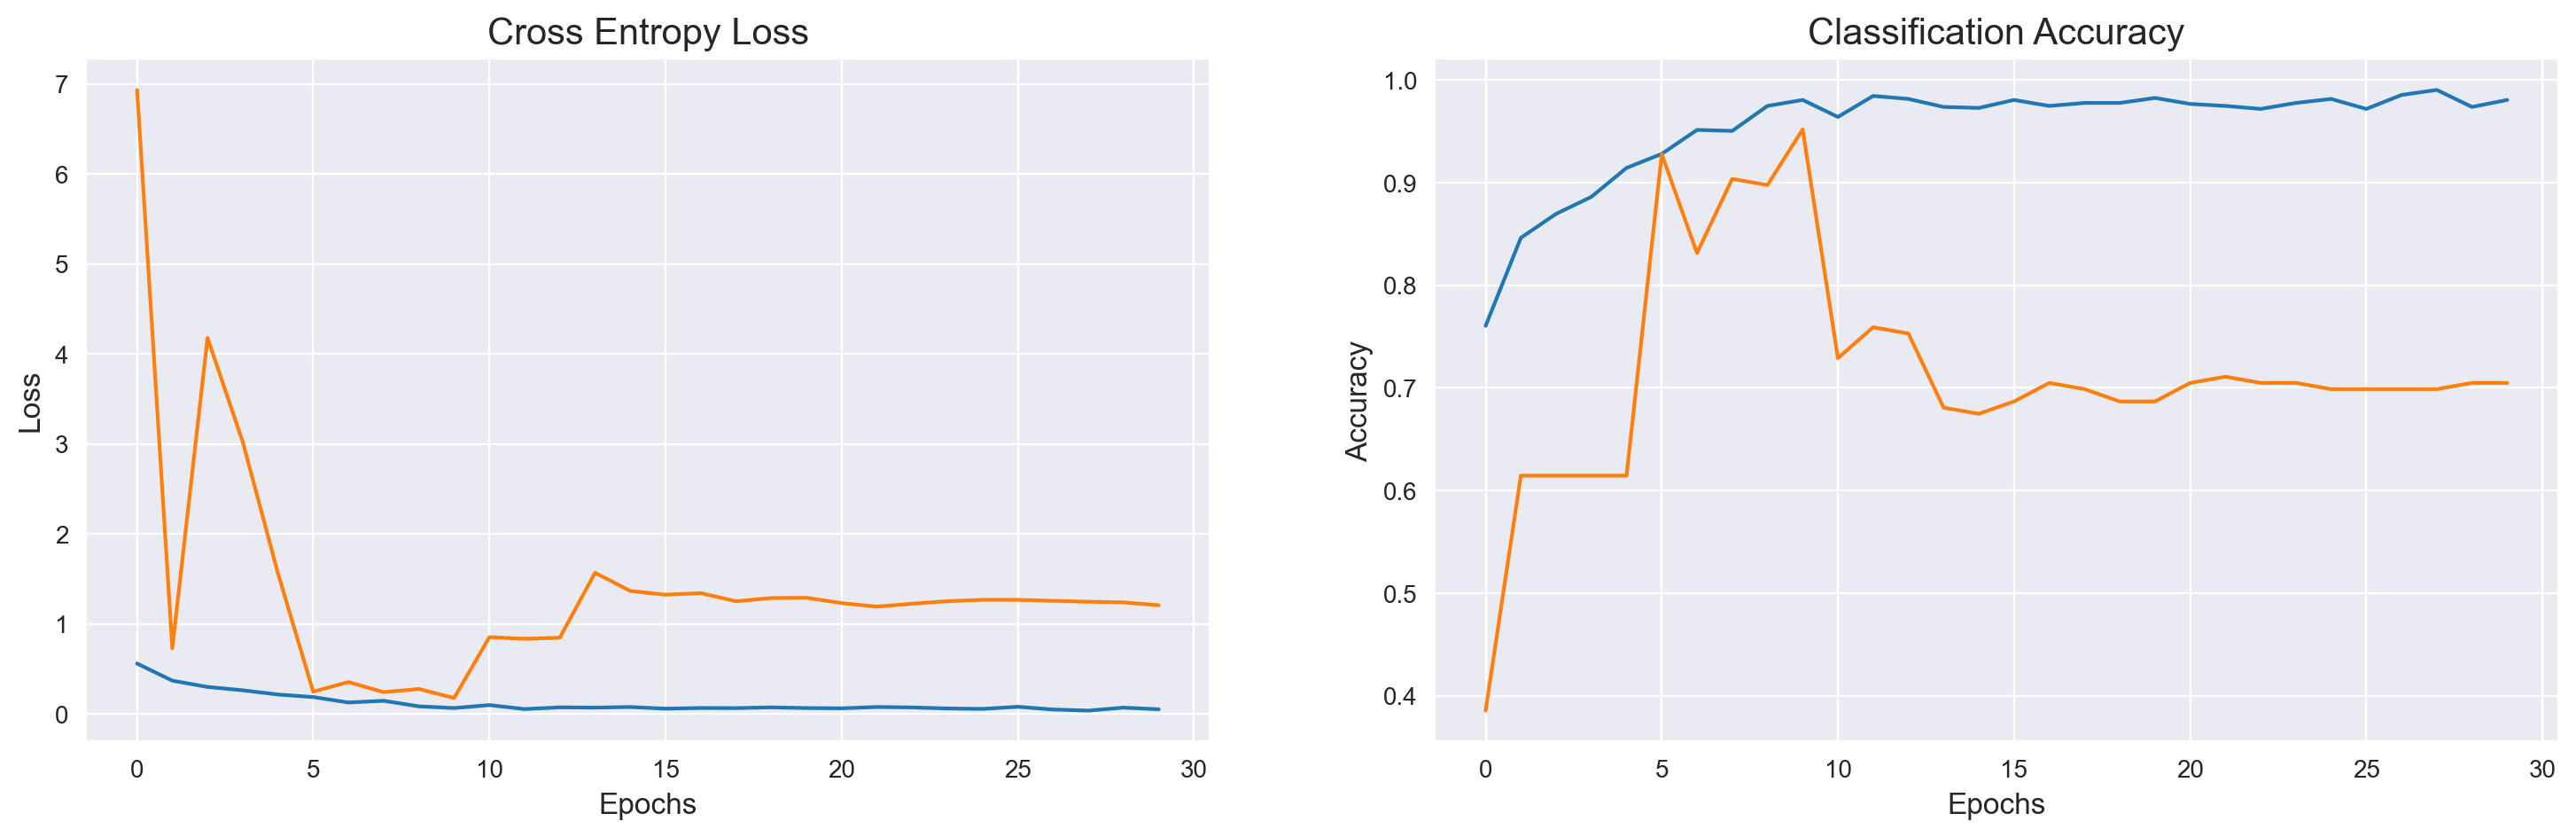

In [161]:
error = pd.DataFrame(horses_humans.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [168]:
# prediction
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = (result > 0.5).astype("int32").flatten()  # Ngưỡng 0.5 cho phân loại nhị phân

# Nhãn thực tế
y_true = test_generator.classes  # Hoặc test_generator.labels nếu classes không có

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 95.34883499145508
The Loss of the model for testing data is: 0.20637920498847961


In [167]:
from sklearn.metrics import classification_report
labels =['Horses','Humans']
# Dự đoán
y_pred = (result > 0.5).astype("int32").flatten()  # Ngưỡng 0.5 cho phân loại nhị phân

# Nhãn thực tế
y_true = test_generator.classes  # Hoặc test_generator.labels nếu classes không có

# In báo cáo phân loại
print(classification_report(y_true, y_pred,target_names=labels, zero_division=1))

              precision    recall  f1-score   support

      Horses       1.00      0.88      0.94        17
      Humans       0.93      1.00      0.96        26

    accuracy                           0.95        43
   macro avg       0.96      0.94      0.95        43
weighted avg       0.96      0.95      0.95        43

